# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

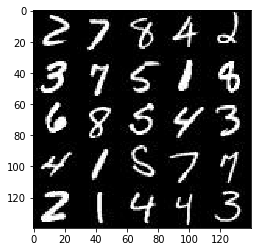

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

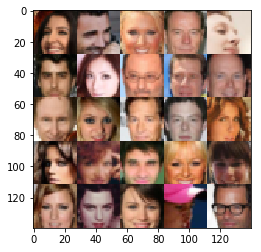

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [22]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate', shape=())

    return real_inputs, z_inputs, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [23]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # no Batch Normalization , first convolutional Layer
        conv1 = tf.layers.conv2d(images, 56, 5, 2, 'SAME')
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        # with Batch Normalization, second convolutional layer
        conv2 = tf.layers.conv2d(conv1, 112, 5, 2, 'SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2)
        
        # third convolutional layer
        conv3 = tf.layers.conv2d(conv2, 224, 5, 2, 'SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3)
        
        # fully connected layer
        flat   = tf.reshape(conv3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        
        # Applying dropout = > discriminator is less prone to learning the data distribution
        logits = tf.layers.dropout(logits, rate=0.5)
        
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [24]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        # for Input fully connected layer
        fully = tf.layers.dense(z, 7*7*112)
        fully = tf.reshape(fully, (-1, 7, 7, 112))
        fully = tf.layers.batch_normalization(fully, training=is_train)
        fully = tf.maximum(alpha*fully, fully)
        
        # with Batch Normalization First convolutional layer
        conv1 = tf.layers.conv2d_transpose(fully, 56, 5, 2, 'SAME')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        # Output convolutional layer
        conv2 = tf.layers.conv2d_transpose(conv1, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(conv2)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


In [26]:
import numpy as np

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Generator model
    g_model = generator(input_z, out_channel_dim)
    
    # Discriminator model
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    # Loss for Discriminator
    # Using on labels 'One Sided Label Smoothing' 
    d_loss_real = tf.reduce_mean( \
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, \
        labels=tf.ones_like(d_logits_real)*np.random.uniform(0.7, 1.2)))
    d_loss_fake=tf.reduce_mean( \
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, \
        labels=tf.zeros_like(d_logits_fake)*np.random.uniform(0.0, 0.3)))
    d_loss = d_loss_real + d_loss_fake
    
    # Loss for Generator
    g_loss = tf.reduce_mean( \
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # getting discriminator and generator variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # running the  optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt  


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0
    print_every = 10
    show_every = 100
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # normalize input to be between -1 and 1 to match generator's images
                batch_images = batch_images*2
                
                # get input noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
            
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2219... Generator Loss: 1.8422
Epoch 1/2... Discriminator Loss: 0.4950... Generator Loss: 1.1981
Epoch 1/2... Discriminator Loss: 0.3614... Generator Loss: 1.6730
Epoch 1/2... Discriminator Loss: 0.3815... Generator Loss: 1.4265
Epoch 1/2... Discriminator Loss: 0.2782... Generator Loss: 2.2390
Epoch 1/2... Discriminator Loss: 0.6773... Generator Loss: 0.8676
Epoch 1/2... Discriminator Loss: 0.2552... Generator Loss: 2.6660
Epoch 1/2... Discriminator Loss: 0.5154... Generator Loss: 1.2659
Epoch 1/2... Discriminator Loss: 0.3560... Generator Loss: 1.6278
Epoch 1/2... Discriminator Loss: 1.1670... Generator Loss: 0.5012


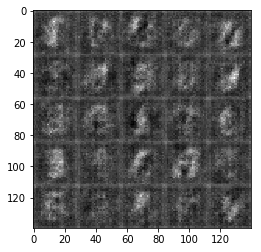

Epoch 1/2... Discriminator Loss: 0.7585... Generator Loss: 0.7694
Epoch 1/2... Discriminator Loss: 1.7384... Generator Loss: 0.2578
Epoch 1/2... Discriminator Loss: 0.5396... Generator Loss: 1.2176
Epoch 1/2... Discriminator Loss: 2.0248... Generator Loss: 0.1920
Epoch 1/2... Discriminator Loss: 0.6435... Generator Loss: 0.9477
Epoch 1/2... Discriminator Loss: 1.0390... Generator Loss: 0.5414
Epoch 1/2... Discriminator Loss: 0.4736... Generator Loss: 1.3850
Epoch 1/2... Discriminator Loss: 0.9855... Generator Loss: 0.6177
Epoch 1/2... Discriminator Loss: 0.4646... Generator Loss: 1.3443
Epoch 1/2... Discriminator Loss: 0.8006... Generator Loss: 3.2336


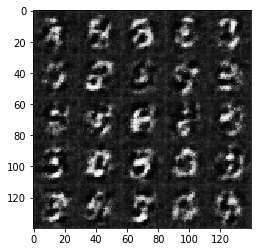

Epoch 1/2... Discriminator Loss: 0.4668... Generator Loss: 1.5210
Epoch 1/2... Discriminator Loss: 0.5867... Generator Loss: 0.9227
Epoch 1/2... Discriminator Loss: 0.7525... Generator Loss: 0.7884
Epoch 1/2... Discriminator Loss: 0.8160... Generator Loss: 0.6891
Epoch 1/2... Discriminator Loss: 1.3720... Generator Loss: 0.3209
Epoch 1/2... Discriminator Loss: 0.3633... Generator Loss: 1.6661
Epoch 1/2... Discriminator Loss: 0.5081... Generator Loss: 1.5811
Epoch 1/2... Discriminator Loss: 0.8314... Generator Loss: 0.6894
Epoch 1/2... Discriminator Loss: 0.5359... Generator Loss: 1.1007
Epoch 1/2... Discriminator Loss: 1.3404... Generator Loss: 0.4321


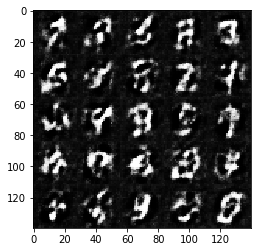

Epoch 1/2... Discriminator Loss: 0.5443... Generator Loss: 1.0289
Epoch 1/2... Discriminator Loss: 0.6489... Generator Loss: 0.9375
Epoch 1/2... Discriminator Loss: 0.6226... Generator Loss: 0.8802
Epoch 1/2... Discriminator Loss: 0.6857... Generator Loss: 0.8571
Epoch 1/2... Discriminator Loss: 0.5939... Generator Loss: 2.9898
Epoch 1/2... Discriminator Loss: 0.3552... Generator Loss: 1.8987
Epoch 1/2... Discriminator Loss: 0.8582... Generator Loss: 0.6488
Epoch 1/2... Discriminator Loss: 0.3107... Generator Loss: 1.9278
Epoch 1/2... Discriminator Loss: 0.5309... Generator Loss: 1.1176
Epoch 1/2... Discriminator Loss: 1.4198... Generator Loss: 0.3535


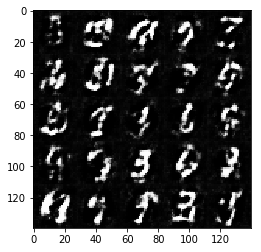

Epoch 1/2... Discriminator Loss: 0.5121... Generator Loss: 1.2222
Epoch 1/2... Discriminator Loss: 0.3813... Generator Loss: 1.6694
Epoch 1/2... Discriminator Loss: 0.3988... Generator Loss: 1.5956
Epoch 1/2... Discriminator Loss: 0.3626... Generator Loss: 1.6605
Epoch 1/2... Discriminator Loss: 0.4007... Generator Loss: 3.3973
Epoch 1/2... Discriminator Loss: 0.4380... Generator Loss: 1.3533
Epoch 1/2... Discriminator Loss: 0.2840... Generator Loss: 1.9181
Epoch 1/2... Discriminator Loss: 1.4021... Generator Loss: 0.3459
Epoch 1/2... Discriminator Loss: 0.3630... Generator Loss: 1.5742
Epoch 1/2... Discriminator Loss: 0.4490... Generator Loss: 1.3335


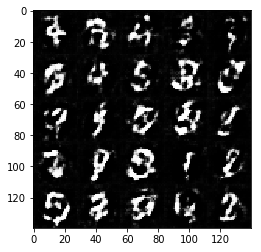

Epoch 1/2... Discriminator Loss: 0.4740... Generator Loss: 1.5088
Epoch 1/2... Discriminator Loss: 1.0147... Generator Loss: 4.6127
Epoch 1/2... Discriminator Loss: 0.3857... Generator Loss: 1.6865
Epoch 1/2... Discriminator Loss: 0.4146... Generator Loss: 1.3538
Epoch 1/2... Discriminator Loss: 0.3653... Generator Loss: 1.7222
Epoch 1/2... Discriminator Loss: 0.2860... Generator Loss: 2.0673
Epoch 1/2... Discriminator Loss: 0.3364... Generator Loss: 1.9173
Epoch 1/2... Discriminator Loss: 0.3308... Generator Loss: 1.6003
Epoch 1/2... Discriminator Loss: 0.2984... Generator Loss: 2.1177
Epoch 1/2... Discriminator Loss: 0.4353... Generator Loss: 1.3235


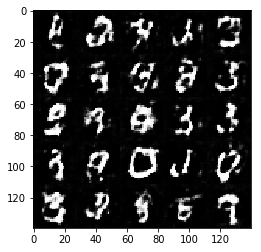

Epoch 1/2... Discriminator Loss: 0.6889... Generator Loss: 0.8256
Epoch 1/2... Discriminator Loss: 0.3268... Generator Loss: 1.8235
Epoch 1/2... Discriminator Loss: 0.3123... Generator Loss: 2.5713
Epoch 1/2... Discriminator Loss: 0.5337... Generator Loss: 1.2062
Epoch 1/2... Discriminator Loss: 0.6997... Generator Loss: 4.9428
Epoch 1/2... Discriminator Loss: 0.4785... Generator Loss: 1.3089
Epoch 1/2... Discriminator Loss: 0.5284... Generator Loss: 1.3345
Epoch 1/2... Discriminator Loss: 0.3966... Generator Loss: 2.5999
Epoch 1/2... Discriminator Loss: 1.1351... Generator Loss: 0.5197
Epoch 1/2... Discriminator Loss: 0.2299... Generator Loss: 2.1961


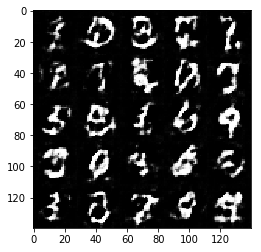

Epoch 1/2... Discriminator Loss: 0.5691... Generator Loss: 1.1428
Epoch 1/2... Discriminator Loss: 0.9980... Generator Loss: 0.6324
Epoch 1/2... Discriminator Loss: 0.4386... Generator Loss: 1.7006
Epoch 1/2... Discriminator Loss: 0.6041... Generator Loss: 0.9994
Epoch 1/2... Discriminator Loss: 0.9741... Generator Loss: 0.7293
Epoch 1/2... Discriminator Loss: 1.3179... Generator Loss: 0.4553
Epoch 1/2... Discriminator Loss: 0.7134... Generator Loss: 1.1008
Epoch 1/2... Discriminator Loss: 0.4045... Generator Loss: 1.6160
Epoch 1/2... Discriminator Loss: 0.7801... Generator Loss: 0.8092
Epoch 1/2... Discriminator Loss: 0.4558... Generator Loss: 2.5814


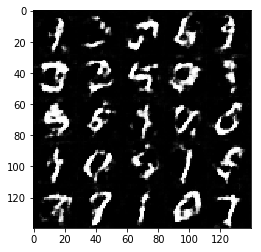

Epoch 1/2... Discriminator Loss: 0.4526... Generator Loss: 1.3647
Epoch 1/2... Discriminator Loss: 0.5070... Generator Loss: 1.2843
Epoch 1/2... Discriminator Loss: 1.1423... Generator Loss: 0.5401
Epoch 1/2... Discriminator Loss: 0.3839... Generator Loss: 1.8279
Epoch 1/2... Discriminator Loss: 0.3240... Generator Loss: 1.9770
Epoch 1/2... Discriminator Loss: 0.9420... Generator Loss: 0.7384
Epoch 1/2... Discriminator Loss: 0.4511... Generator Loss: 1.2155
Epoch 1/2... Discriminator Loss: 0.4985... Generator Loss: 1.0954
Epoch 1/2... Discriminator Loss: 0.3740... Generator Loss: 2.6561
Epoch 1/2... Discriminator Loss: 0.8125... Generator Loss: 0.7823


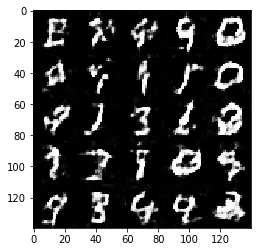

Epoch 1/2... Discriminator Loss: 0.8660... Generator Loss: 4.5749
Epoch 1/2... Discriminator Loss: 0.4785... Generator Loss: 1.2269
Epoch 1/2... Discriminator Loss: 0.3772... Generator Loss: 1.6262
Epoch 1/2... Discriminator Loss: 0.6738... Generator Loss: 0.9033
Epoch 1/2... Discriminator Loss: 1.0648... Generator Loss: 0.4999
Epoch 1/2... Discriminator Loss: 0.7888... Generator Loss: 0.8888
Epoch 1/2... Discriminator Loss: 0.4679... Generator Loss: 1.1955
Epoch 1/2... Discriminator Loss: 0.4296... Generator Loss: 1.3695
Epoch 1/2... Discriminator Loss: 0.6998... Generator Loss: 2.9565
Epoch 1/2... Discriminator Loss: 0.9272... Generator Loss: 0.6262


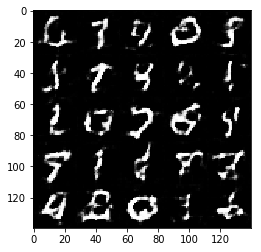

Epoch 1/2... Discriminator Loss: 0.4513... Generator Loss: 1.3243
Epoch 1/2... Discriminator Loss: 0.4064... Generator Loss: 1.4591
Epoch 1/2... Discriminator Loss: 0.9045... Generator Loss: 0.8378
Epoch 1/2... Discriminator Loss: 1.6213... Generator Loss: 0.3538
Epoch 1/2... Discriminator Loss: 0.5069... Generator Loss: 1.3778
Epoch 1/2... Discriminator Loss: 0.4158... Generator Loss: 1.4770
Epoch 1/2... Discriminator Loss: 0.6146... Generator Loss: 1.0054
Epoch 1/2... Discriminator Loss: 0.5911... Generator Loss: 1.1578
Epoch 1/2... Discriminator Loss: 0.3526... Generator Loss: 1.6082
Epoch 1/2... Discriminator Loss: 0.5102... Generator Loss: 1.4076


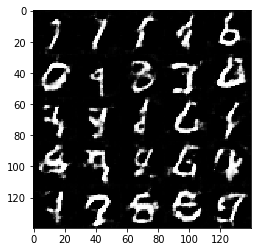

Epoch 1/2... Discriminator Loss: 0.7859... Generator Loss: 0.7857
Epoch 1/2... Discriminator Loss: 0.4666... Generator Loss: 1.2978
Epoch 1/2... Discriminator Loss: 0.3191... Generator Loss: 1.6514
Epoch 1/2... Discriminator Loss: 0.4663... Generator Loss: 1.5218
Epoch 1/2... Discriminator Loss: 3.0383... Generator Loss: 6.9486
Epoch 1/2... Discriminator Loss: 0.5989... Generator Loss: 1.0923
Epoch 1/2... Discriminator Loss: 0.4810... Generator Loss: 1.4697
Epoch 1/2... Discriminator Loss: 0.4541... Generator Loss: 1.2555
Epoch 1/2... Discriminator Loss: 0.4142... Generator Loss: 1.8080
Epoch 1/2... Discriminator Loss: 0.3505... Generator Loss: 1.9698


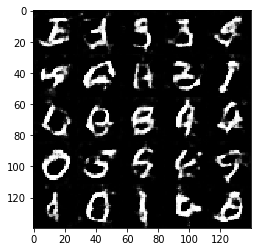

Epoch 1/2... Discriminator Loss: 1.1257... Generator Loss: 0.5324
Epoch 1/2... Discriminator Loss: 0.5781... Generator Loss: 1.0970
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 0.5359
Epoch 1/2... Discriminator Loss: 0.8240... Generator Loss: 0.7908
Epoch 1/2... Discriminator Loss: 1.4399... Generator Loss: 0.3639
Epoch 1/2... Discriminator Loss: 0.3638... Generator Loss: 1.4648
Epoch 1/2... Discriminator Loss: 0.7169... Generator Loss: 0.8738
Epoch 1/2... Discriminator Loss: 1.2777... Generator Loss: 5.0070
Epoch 1/2... Discriminator Loss: 0.4077... Generator Loss: 1.6724
Epoch 1/2... Discriminator Loss: 0.4185... Generator Loss: 1.3991


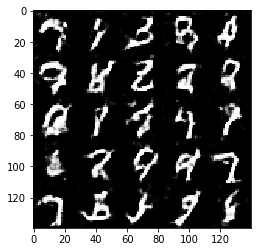

Epoch 1/2... Discriminator Loss: 0.3141... Generator Loss: 1.8892
Epoch 1/2... Discriminator Loss: 0.6473... Generator Loss: 1.0311
Epoch 1/2... Discriminator Loss: 1.4373... Generator Loss: 0.4047
Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 0.4918
Epoch 1/2... Discriminator Loss: 0.5366... Generator Loss: 1.2700
Epoch 1/2... Discriminator Loss: 0.8355... Generator Loss: 0.7611
Epoch 1/2... Discriminator Loss: 0.5152... Generator Loss: 1.2366
Epoch 1/2... Discriminator Loss: 0.4622... Generator Loss: 1.2991
Epoch 1/2... Discriminator Loss: 0.5201... Generator Loss: 1.2273
Epoch 1/2... Discriminator Loss: 0.4975... Generator Loss: 1.3305


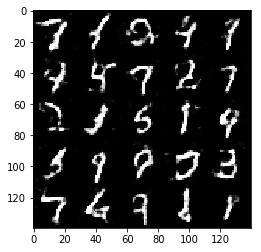

Epoch 1/2... Discriminator Loss: 1.8301... Generator Loss: 5.0771
Epoch 1/2... Discriminator Loss: 0.3761... Generator Loss: 1.6037
Epoch 1/2... Discriminator Loss: 0.4721... Generator Loss: 1.2635
Epoch 1/2... Discriminator Loss: 0.5496... Generator Loss: 1.3010
Epoch 1/2... Discriminator Loss: 0.4134... Generator Loss: 1.5082
Epoch 1/2... Discriminator Loss: 0.7887... Generator Loss: 0.8585
Epoch 1/2... Discriminator Loss: 0.5332... Generator Loss: 1.1395
Epoch 1/2... Discriminator Loss: 0.7092... Generator Loss: 0.8754
Epoch 1/2... Discriminator Loss: 0.5112... Generator Loss: 1.1560
Epoch 1/2... Discriminator Loss: 0.6356... Generator Loss: 1.1984


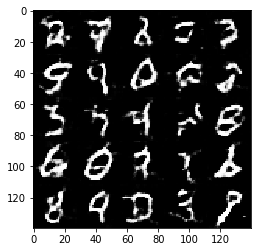

Epoch 1/2... Discriminator Loss: 0.7420... Generator Loss: 0.8625
Epoch 1/2... Discriminator Loss: 0.7012... Generator Loss: 0.8491
Epoch 1/2... Discriminator Loss: 0.5079... Generator Loss: 1.1512
Epoch 1/2... Discriminator Loss: 1.5509... Generator Loss: 6.2469
Epoch 1/2... Discriminator Loss: 0.6435... Generator Loss: 2.4358
Epoch 1/2... Discriminator Loss: 0.3521... Generator Loss: 1.6737
Epoch 1/2... Discriminator Loss: 0.4748... Generator Loss: 1.3542
Epoch 1/2... Discriminator Loss: 0.6980... Generator Loss: 0.9974
Epoch 1/2... Discriminator Loss: 0.8023... Generator Loss: 0.8071
Epoch 1/2... Discriminator Loss: 0.7591... Generator Loss: 0.8133


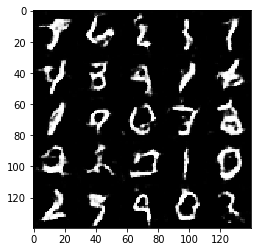

Epoch 1/2... Discriminator Loss: 0.6131... Generator Loss: 1.0241
Epoch 1/2... Discriminator Loss: 0.5926... Generator Loss: 0.9888
Epoch 1/2... Discriminator Loss: 0.6556... Generator Loss: 0.9811
Epoch 1/2... Discriminator Loss: 0.4519... Generator Loss: 1.3840
Epoch 1/2... Discriminator Loss: 1.6783... Generator Loss: 0.3533
Epoch 1/2... Discriminator Loss: 0.5802... Generator Loss: 1.1176
Epoch 1/2... Discriminator Loss: 1.2482... Generator Loss: 0.5724
Epoch 1/2... Discriminator Loss: 0.3897... Generator Loss: 1.2900
Epoch 1/2... Discriminator Loss: 0.2760... Generator Loss: 1.7097
Epoch 1/2... Discriminator Loss: 0.7382... Generator Loss: 0.8121


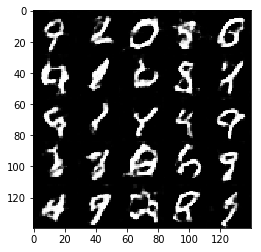

Epoch 1/2... Discriminator Loss: 0.6755... Generator Loss: 0.8551
Epoch 1/2... Discriminator Loss: 0.5917... Generator Loss: 1.0471
Epoch 1/2... Discriminator Loss: 0.3517... Generator Loss: 1.5716
Epoch 1/2... Discriminator Loss: 0.5336... Generator Loss: 1.2049
Epoch 1/2... Discriminator Loss: 0.4893... Generator Loss: 1.1973
Epoch 1/2... Discriminator Loss: 0.4832... Generator Loss: 1.3359
Epoch 1/2... Discriminator Loss: 0.5519... Generator Loss: 1.1406
Epoch 1/2... Discriminator Loss: 1.5449... Generator Loss: 0.3472
Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 0.7859
Epoch 1/2... Discriminator Loss: 1.0619... Generator Loss: 3.3443


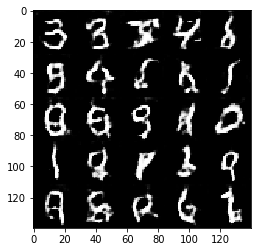

Epoch 1/2... Discriminator Loss: 0.4935... Generator Loss: 1.2477
Epoch 1/2... Discriminator Loss: 0.4006... Generator Loss: 2.3294
Epoch 1/2... Discriminator Loss: 0.2195... Generator Loss: 2.5664
Epoch 1/2... Discriminator Loss: 0.3507... Generator Loss: 1.5330
Epoch 1/2... Discriminator Loss: 0.5464... Generator Loss: 1.1470
Epoch 1/2... Discriminator Loss: 0.4091... Generator Loss: 2.6528
Epoch 1/2... Discriminator Loss: 0.7577... Generator Loss: 0.8572
Epoch 2/2... Discriminator Loss: 0.4048... Generator Loss: 1.3692
Epoch 2/2... Discriminator Loss: 0.4682... Generator Loss: 1.3945
Epoch 2/2... Discriminator Loss: 0.6049... Generator Loss: 1.1453


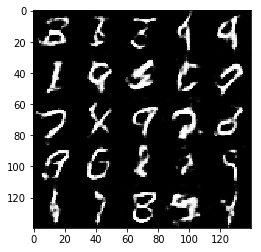

Epoch 2/2... Discriminator Loss: 0.3469... Generator Loss: 1.5137
Epoch 2/2... Discriminator Loss: 0.3765... Generator Loss: 1.3852
Epoch 2/2... Discriminator Loss: 0.3255... Generator Loss: 2.3502
Epoch 2/2... Discriminator Loss: 0.3896... Generator Loss: 1.3405
Epoch 2/2... Discriminator Loss: 0.3439... Generator Loss: 1.6177
Epoch 2/2... Discriminator Loss: 0.4609... Generator Loss: 1.3242
Epoch 2/2... Discriminator Loss: 0.6613... Generator Loss: 0.9988
Epoch 2/2... Discriminator Loss: 0.3934... Generator Loss: 1.9691
Epoch 2/2... Discriminator Loss: 1.1178... Generator Loss: 4.5001
Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 3.4574


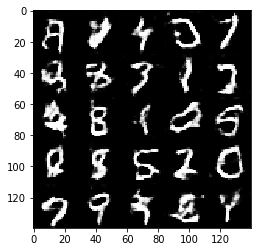

Epoch 2/2... Discriminator Loss: 0.8863... Generator Loss: 0.7110
Epoch 2/2... Discriminator Loss: 0.5141... Generator Loss: 1.1997
Epoch 2/2... Discriminator Loss: 1.0021... Generator Loss: 0.5955
Epoch 2/2... Discriminator Loss: 0.3312... Generator Loss: 1.5527
Epoch 2/2... Discriminator Loss: 0.3292... Generator Loss: 1.7087
Epoch 2/2... Discriminator Loss: 0.5710... Generator Loss: 1.0587
Epoch 2/2... Discriminator Loss: 0.6734... Generator Loss: 0.9979
Epoch 2/2... Discriminator Loss: 0.4206... Generator Loss: 1.3346
Epoch 2/2... Discriminator Loss: 0.5488... Generator Loss: 1.0644
Epoch 2/2... Discriminator Loss: 1.5929... Generator Loss: 0.4077


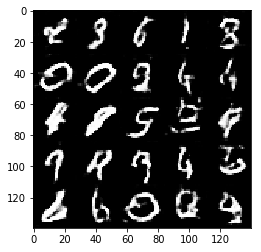

Epoch 2/2... Discriminator Loss: 0.6819... Generator Loss: 0.9248
Epoch 2/2... Discriminator Loss: 0.4384... Generator Loss: 1.5922
Epoch 2/2... Discriminator Loss: 0.6007... Generator Loss: 1.0889
Epoch 2/2... Discriminator Loss: 0.4502... Generator Loss: 1.3488
Epoch 2/2... Discriminator Loss: 0.6433... Generator Loss: 1.0111
Epoch 2/2... Discriminator Loss: 0.5276... Generator Loss: 1.1764
Epoch 2/2... Discriminator Loss: 0.5319... Generator Loss: 1.0727
Epoch 2/2... Discriminator Loss: 0.7316... Generator Loss: 0.8182
Epoch 2/2... Discriminator Loss: 0.4647... Generator Loss: 1.2811
Epoch 2/2... Discriminator Loss: 0.5599... Generator Loss: 1.0820


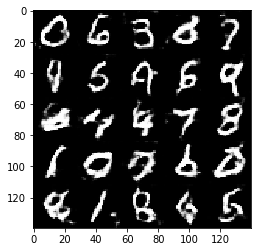

Epoch 2/2... Discriminator Loss: 0.4817... Generator Loss: 1.2570
Epoch 2/2... Discriminator Loss: 0.4577... Generator Loss: 1.4398
Epoch 2/2... Discriminator Loss: 0.4301... Generator Loss: 1.4204
Epoch 2/2... Discriminator Loss: 0.8231... Generator Loss: 0.8135
Epoch 2/2... Discriminator Loss: 0.8226... Generator Loss: 0.7601
Epoch 2/2... Discriminator Loss: 0.4680... Generator Loss: 1.1612
Epoch 2/2... Discriminator Loss: 0.8488... Generator Loss: 0.6925
Epoch 2/2... Discriminator Loss: 0.7993... Generator Loss: 0.8793
Epoch 2/2... Discriminator Loss: 0.8047... Generator Loss: 0.8444
Epoch 2/2... Discriminator Loss: 0.6451... Generator Loss: 0.9614


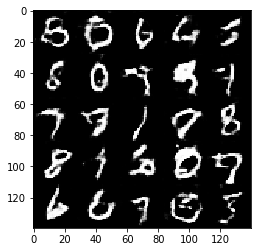

Epoch 2/2... Discriminator Loss: 0.5658... Generator Loss: 1.1741
Epoch 2/2... Discriminator Loss: 0.4592... Generator Loss: 1.2531
Epoch 2/2... Discriminator Loss: 0.6378... Generator Loss: 1.0428
Epoch 2/2... Discriminator Loss: 0.5243... Generator Loss: 1.1737
Epoch 2/2... Discriminator Loss: 0.6317... Generator Loss: 0.9852
Epoch 2/2... Discriminator Loss: 4.1917... Generator Loss: 7.0749
Epoch 2/2... Discriminator Loss: 0.6959... Generator Loss: 3.1567
Epoch 2/2... Discriminator Loss: 0.4369... Generator Loss: 1.8353
Epoch 2/2... Discriminator Loss: 0.7687... Generator Loss: 0.8539
Epoch 2/2... Discriminator Loss: 0.5076... Generator Loss: 3.7799


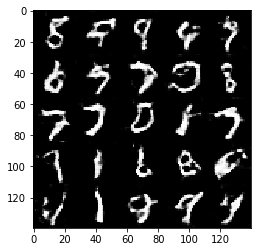

Epoch 2/2... Discriminator Loss: 0.4018... Generator Loss: 1.5155
Epoch 2/2... Discriminator Loss: 0.6081... Generator Loss: 1.0261
Epoch 2/2... Discriminator Loss: 0.5026... Generator Loss: 1.3006
Epoch 2/2... Discriminator Loss: 0.6859... Generator Loss: 0.9065
Epoch 2/2... Discriminator Loss: 0.2848... Generator Loss: 1.5851
Epoch 2/2... Discriminator Loss: 0.7710... Generator Loss: 0.8523
Epoch 2/2... Discriminator Loss: 0.4272... Generator Loss: 1.3885
Epoch 2/2... Discriminator Loss: 0.4989... Generator Loss: 1.2641
Epoch 2/2... Discriminator Loss: 0.3693... Generator Loss: 1.4408
Epoch 2/2... Discriminator Loss: 0.4256... Generator Loss: 1.3001


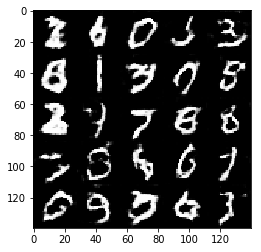

Epoch 2/2... Discriminator Loss: 0.4080... Generator Loss: 1.4025
Epoch 2/2... Discriminator Loss: 0.4120... Generator Loss: 1.5544
Epoch 2/2... Discriminator Loss: 0.5234... Generator Loss: 1.2190
Epoch 2/2... Discriminator Loss: 2.5500... Generator Loss: 6.6919
Epoch 2/2... Discriminator Loss: 0.5275... Generator Loss: 2.9387
Epoch 2/2... Discriminator Loss: 0.3985... Generator Loss: 1.6397
Epoch 2/2... Discriminator Loss: 0.7481... Generator Loss: 0.7870
Epoch 2/2... Discriminator Loss: 0.7014... Generator Loss: 0.9009
Epoch 2/2... Discriminator Loss: 0.4722... Generator Loss: 1.1717
Epoch 2/2... Discriminator Loss: 0.8553... Generator Loss: 0.7195


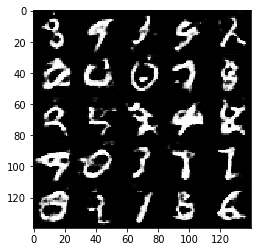

Epoch 2/2... Discriminator Loss: 0.7369... Generator Loss: 0.7825
Epoch 2/2... Discriminator Loss: 0.5192... Generator Loss: 1.2178
Epoch 2/2... Discriminator Loss: 0.6929... Generator Loss: 0.8578
Epoch 2/2... Discriminator Loss: 0.4334... Generator Loss: 1.2296
Epoch 2/2... Discriminator Loss: 0.2468... Generator Loss: 1.9918
Epoch 2/2... Discriminator Loss: 0.8648... Generator Loss: 0.7271
Epoch 2/2... Discriminator Loss: 1.0097... Generator Loss: 0.6453
Epoch 2/2... Discriminator Loss: 0.7922... Generator Loss: 0.6421
Epoch 2/2... Discriminator Loss: 0.4689... Generator Loss: 1.3366
Epoch 2/2... Discriminator Loss: 0.4404... Generator Loss: 2.2916


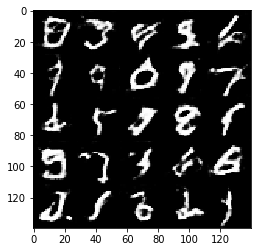

Epoch 2/2... Discriminator Loss: 0.7041... Generator Loss: 1.1070
Epoch 2/2... Discriminator Loss: 0.5832... Generator Loss: 1.0586
Epoch 2/2... Discriminator Loss: 0.4012... Generator Loss: 1.3280
Epoch 2/2... Discriminator Loss: 1.0085... Generator Loss: 0.6345
Epoch 2/2... Discriminator Loss: 0.3724... Generator Loss: 1.4744
Epoch 2/2... Discriminator Loss: 1.0794... Generator Loss: 0.5262
Epoch 2/2... Discriminator Loss: 0.3855... Generator Loss: 1.4444
Epoch 2/2... Discriminator Loss: 0.3740... Generator Loss: 1.6104
Epoch 2/2... Discriminator Loss: 0.4739... Generator Loss: 1.1809
Epoch 2/2... Discriminator Loss: 1.0001... Generator Loss: 0.6201


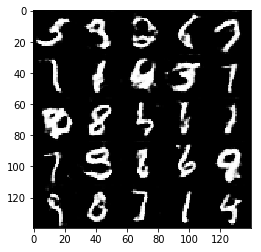

Epoch 2/2... Discriminator Loss: 0.2611... Generator Loss: 2.0757
Epoch 2/2... Discriminator Loss: 0.6747... Generator Loss: 0.9789
Epoch 2/2... Discriminator Loss: 0.6818... Generator Loss: 0.8644
Epoch 2/2... Discriminator Loss: 0.5672... Generator Loss: 3.9714
Epoch 2/2... Discriminator Loss: 0.5205... Generator Loss: 1.2042
Epoch 2/2... Discriminator Loss: 0.3656... Generator Loss: 1.5466
Epoch 2/2... Discriminator Loss: 0.3349... Generator Loss: 1.5596
Epoch 2/2... Discriminator Loss: 0.2955... Generator Loss: 1.7255
Epoch 2/2... Discriminator Loss: 0.3516... Generator Loss: 1.5072
Epoch 2/2... Discriminator Loss: 0.3887... Generator Loss: 1.5554


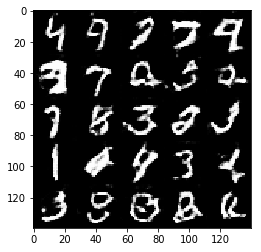

Epoch 2/2... Discriminator Loss: 0.2991... Generator Loss: 1.6697
Epoch 2/2... Discriminator Loss: 0.5696... Generator Loss: 1.0156
Epoch 2/2... Discriminator Loss: 0.5676... Generator Loss: 1.1216
Epoch 2/2... Discriminator Loss: 0.6960... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 0.8828... Generator Loss: 0.7201
Epoch 2/2... Discriminator Loss: 0.6123... Generator Loss: 1.1447
Epoch 2/2... Discriminator Loss: 0.8541... Generator Loss: 0.7442
Epoch 2/2... Discriminator Loss: 0.7197... Generator Loss: 0.8764
Epoch 2/2... Discriminator Loss: 0.5822... Generator Loss: 1.0648
Epoch 2/2... Discriminator Loss: 1.2744... Generator Loss: 0.5290


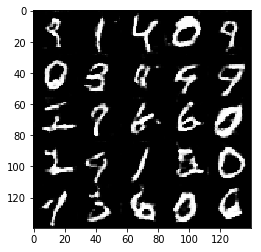

Epoch 2/2... Discriminator Loss: 0.3989... Generator Loss: 1.4153
Epoch 2/2... Discriminator Loss: 0.5230... Generator Loss: 1.3700
Epoch 2/2... Discriminator Loss: 0.5550... Generator Loss: 1.3941
Epoch 2/2... Discriminator Loss: 0.4190... Generator Loss: 1.4179
Epoch 2/2... Discriminator Loss: 0.7923... Generator Loss: 0.8305
Epoch 2/2... Discriminator Loss: 1.4433... Generator Loss: 0.4130
Epoch 2/2... Discriminator Loss: 0.5610... Generator Loss: 1.1816
Epoch 2/2... Discriminator Loss: 0.3016... Generator Loss: 1.6874
Epoch 2/2... Discriminator Loss: 0.4836... Generator Loss: 1.2625
Epoch 2/2... Discriminator Loss: 0.3839... Generator Loss: 1.2672


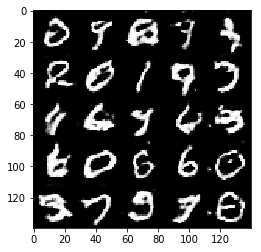

Epoch 2/2... Discriminator Loss: 1.6276... Generator Loss: 0.3164
Epoch 2/2... Discriminator Loss: 5.1710... Generator Loss: 9.6467
Epoch 2/2... Discriminator Loss: 0.4464... Generator Loss: 1.3678
Epoch 2/2... Discriminator Loss: 0.3630... Generator Loss: 1.5434
Epoch 2/2... Discriminator Loss: 0.5919... Generator Loss: 1.0040
Epoch 2/2... Discriminator Loss: 0.9113... Generator Loss: 0.6927
Epoch 2/2... Discriminator Loss: 0.4561... Generator Loss: 1.3783
Epoch 2/2... Discriminator Loss: 0.6368... Generator Loss: 0.9184
Epoch 2/2... Discriminator Loss: 0.6238... Generator Loss: 0.9250
Epoch 2/2... Discriminator Loss: 0.4069... Generator Loss: 1.4834


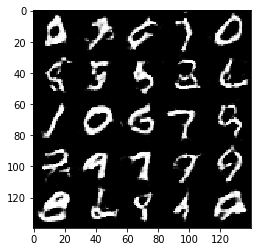

Epoch 2/2... Discriminator Loss: 0.6262... Generator Loss: 1.0597
Epoch 2/2... Discriminator Loss: 0.3609... Generator Loss: 1.6980
Epoch 2/2... Discriminator Loss: 0.3788... Generator Loss: 1.3269
Epoch 2/2... Discriminator Loss: 0.5234... Generator Loss: 1.2085
Epoch 2/2... Discriminator Loss: 0.5740... Generator Loss: 1.0708
Epoch 2/2... Discriminator Loss: 0.5072... Generator Loss: 1.0693
Epoch 2/2... Discriminator Loss: 0.4158... Generator Loss: 1.2684
Epoch 2/2... Discriminator Loss: 0.4198... Generator Loss: 1.4795
Epoch 2/2... Discriminator Loss: 1.4039... Generator Loss: 0.5672
Epoch 2/2... Discriminator Loss: 0.4444... Generator Loss: 1.2917


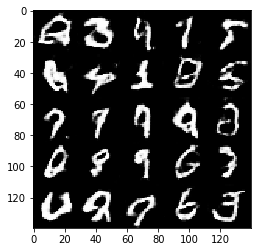

Epoch 2/2... Discriminator Loss: 0.3675... Generator Loss: 1.5368
Epoch 2/2... Discriminator Loss: 2.9971... Generator Loss: 7.3653
Epoch 2/2... Discriminator Loss: 0.3231... Generator Loss: 1.6298
Epoch 2/2... Discriminator Loss: 0.4755... Generator Loss: 3.7271
Epoch 2/2... Discriminator Loss: 0.4999... Generator Loss: 1.1632
Epoch 2/2... Discriminator Loss: 0.4845... Generator Loss: 1.1940
Epoch 2/2... Discriminator Loss: 0.5498... Generator Loss: 1.1062
Epoch 2/2... Discriminator Loss: 0.3854... Generator Loss: 1.3223
Epoch 2/2... Discriminator Loss: 0.4225... Generator Loss: 1.4077
Epoch 2/2... Discriminator Loss: 0.5789... Generator Loss: 1.0934


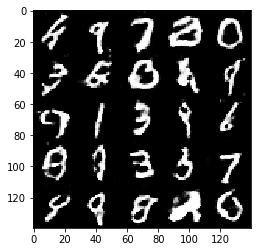

Epoch 2/2... Discriminator Loss: 0.6068... Generator Loss: 1.0248
Epoch 2/2... Discriminator Loss: 0.7879... Generator Loss: 0.8008
Epoch 2/2... Discriminator Loss: 2.0291... Generator Loss: 0.2777
Epoch 2/2... Discriminator Loss: 0.4643... Generator Loss: 1.3425
Epoch 2/2... Discriminator Loss: 0.5363... Generator Loss: 1.0681
Epoch 2/2... Discriminator Loss: 0.3868... Generator Loss: 1.5401
Epoch 2/2... Discriminator Loss: 0.7018... Generator Loss: 0.9146
Epoch 2/2... Discriminator Loss: 0.2404... Generator Loss: 1.8014
Epoch 2/2... Discriminator Loss: 0.7125... Generator Loss: 0.9382
Epoch 2/2... Discriminator Loss: 0.8042... Generator Loss: 0.8136


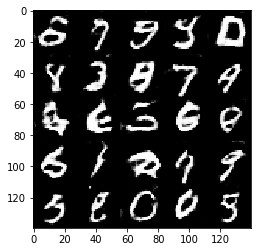

Epoch 2/2... Discriminator Loss: 0.8899... Generator Loss: 0.7322
Epoch 2/2... Discriminator Loss: 0.3404... Generator Loss: 1.5294
Epoch 2/2... Discriminator Loss: 0.6425... Generator Loss: 1.0144
Epoch 2/2... Discriminator Loss: 0.4351... Generator Loss: 1.4224
Epoch 2/2... Discriminator Loss: 0.4724... Generator Loss: 1.3988
Epoch 2/2... Discriminator Loss: 0.3917... Generator Loss: 1.4625
Epoch 2/2... Discriminator Loss: 0.2289... Generator Loss: 2.2047
Epoch 2/2... Discriminator Loss: 0.1729... Generator Loss: 2.2158
Epoch 2/2... Discriminator Loss: 0.5024... Generator Loss: 1.2414
Epoch 2/2... Discriminator Loss: 1.0467... Generator Loss: 0.8568


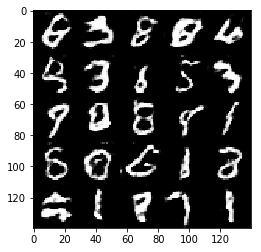

Epoch 2/2... Discriminator Loss: 4.8546... Generator Loss: 0.0506
Epoch 2/2... Discriminator Loss: 0.3292... Generator Loss: 1.9187
Epoch 2/2... Discriminator Loss: 0.3832... Generator Loss: 1.6679
Epoch 2/2... Discriminator Loss: 0.3634... Generator Loss: 1.5443
Epoch 2/2... Discriminator Loss: 0.2145... Generator Loss: 1.8446
Epoch 2/2... Discriminator Loss: 0.3668... Generator Loss: 1.4336
Epoch 2/2... Discriminator Loss: 0.4498... Generator Loss: 1.1604
Epoch 2/2... Discriminator Loss: 0.6269... Generator Loss: 0.9860
Epoch 2/2... Discriminator Loss: 0.4235... Generator Loss: 1.3791
Epoch 2/2... Discriminator Loss: 0.3576... Generator Loss: 1.5299


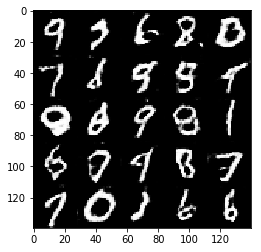

Epoch 2/2... Discriminator Loss: 0.4181... Generator Loss: 1.2690
Epoch 2/2... Discriminator Loss: 0.4331... Generator Loss: 1.3548
Epoch 2/2... Discriminator Loss: 0.4745... Generator Loss: 1.2498
Epoch 2/2... Discriminator Loss: 0.4551... Generator Loss: 1.3558
Epoch 2/2... Discriminator Loss: 0.8944... Generator Loss: 0.7341


In [31]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 1.9308
Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 1.6551
Epoch 1/1... Discriminator Loss: 0.6349... Generator Loss: 2.0909
Epoch 1/1... Discriminator Loss: 0.6704... Generator Loss: 3.8142
Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 2.6705
Epoch 1/1... Discriminator Loss: 0.5347... Generator Loss: 3.0242
Epoch 1/1... Discriminator Loss: 0.5813... Generator Loss: 2.9352
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 3.0888
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 4.6337
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.3650


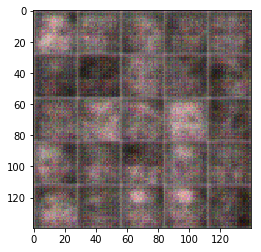

Epoch 1/1... Discriminator Loss: 0.6751... Generator Loss: 2.1835
Epoch 1/1... Discriminator Loss: 2.5490... Generator Loss: 6.4394
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 0.6765... Generator Loss: 1.8187
Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 2.9539
Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 1.2290
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 0.7793... Generator Loss: 1.4956
Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 2.7225
Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 1.9036


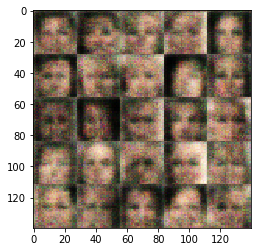

Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.9947
Epoch 1/1... Discriminator Loss: 0.5895... Generator Loss: 2.4155
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 1.1648
Epoch 1/1... Discriminator Loss: 0.6952... Generator Loss: 4.3136
Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 3.3830
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 0.7843... Generator Loss: 2.4859
Epoch 1/1... Discriminator Loss: 0.7684... Generator Loss: 1.8360


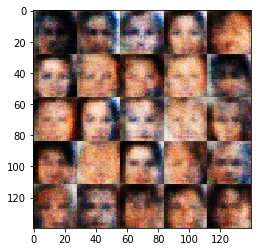

Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.4521
Epoch 1/1... Discriminator Loss: 0.6918... Generator Loss: 2.0254
Epoch 1/1... Discriminator Loss: 2.4879... Generator Loss: 5.1497
Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 1.8928
Epoch 1/1... Discriminator Loss: 0.7059... Generator Loss: 1.7857
Epoch 1/1... Discriminator Loss: 1.6203... Generator Loss: 0.4799
Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 1.7917
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.1597
Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 1.2738
Epoch 1/1... Discriminator Loss: 0.6764... Generator Loss: 2.2826


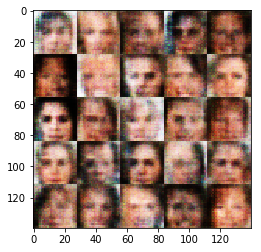

Epoch 1/1... Discriminator Loss: 0.6144... Generator Loss: 2.1353
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 1.9803
Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 1.6791
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.6227... Generator Loss: 2.3714
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 0.6239... Generator Loss: 2.0299
Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 3.2037
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 0.6921... Generator Loss: 1.8534


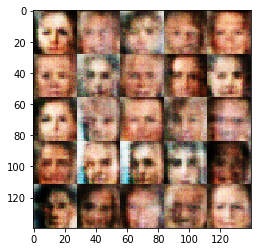

Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 3.6763
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 0.8050... Generator Loss: 1.4145
Epoch 1/1... Discriminator Loss: 1.6107... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 1.5142
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 1.5072
Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 3.8141


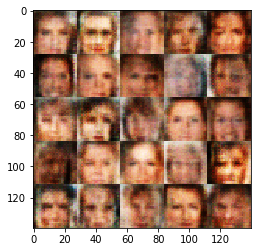

Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 1.2863
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.5204
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.6843
Epoch 1/1... Discriminator Loss: 0.7648... Generator Loss: 1.8938
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 3.5456
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.0579


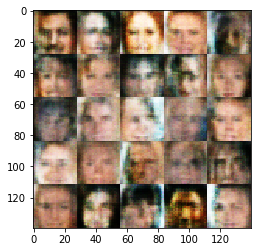

Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 1.2352
Epoch 1/1... Discriminator Loss: 0.7228... Generator Loss: 1.6721
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 2.8020
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.5701
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 2.1587
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 1.2331
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 2.4411


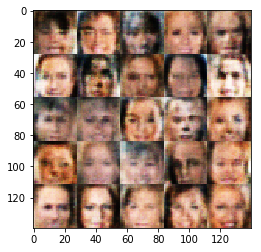

Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.1000
Epoch 1/1... Discriminator Loss: 0.8538... Generator Loss: 1.3513
Epoch 1/1... Discriminator Loss: 2.2768... Generator Loss: 3.9950
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.6846
Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.5912


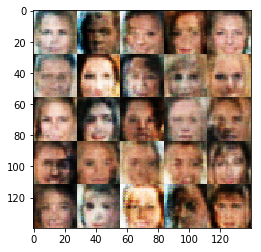

Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 1.5762
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 2.5658
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 2.7888
Epoch 1/1... Discriminator Loss: 0.8385... Generator Loss: 2.4308
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 2.0711
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 2.3535
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 2.4762
Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 1.1632


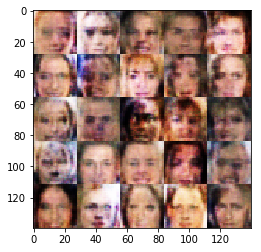

Epoch 1/1... Discriminator Loss: 0.7489... Generator Loss: 1.6059
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 2.6254
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 1.4987
Epoch 1/1... Discriminator Loss: 0.8406... Generator Loss: 1.4503
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.0482
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 1.0350
Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 2.3169
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 2.1794
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.5669
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.7206


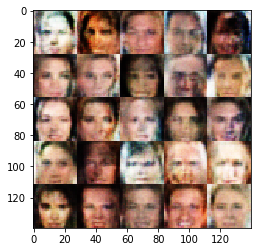

Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 2.6890
Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 1.2950
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 1.7075
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 1.4304
Epoch 1/1... Discriminator Loss: 0.8594... Generator Loss: 2.3486
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 1.3181
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.6954


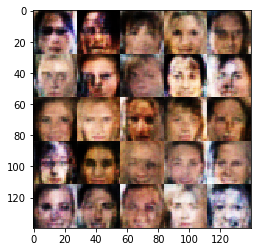

Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 2.1170
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 2.5208
Epoch 1/1... Discriminator Loss: 0.8294... Generator Loss: 1.4082
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 1.0264
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 1.7261
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 1.0368
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.7429


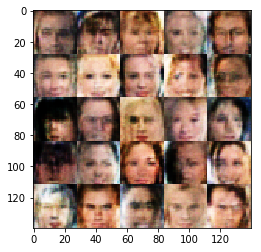

Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 0.9121... Generator Loss: 1.6739
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 0.9151... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 2.5268
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 1.1700
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.7760


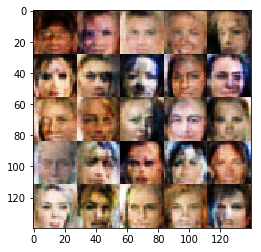

Epoch 1/1... Discriminator Loss: 2.3312... Generator Loss: 4.3708
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 1.2302
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 1.7250
Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 1.0720
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.4870
Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.4631


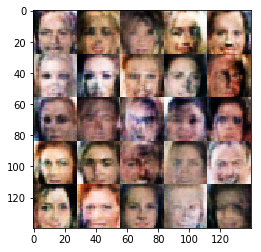

Epoch 1/1... Discriminator Loss: 0.7366... Generator Loss: 1.5082
Epoch 1/1... Discriminator Loss: 0.6959... Generator Loss: 1.6457
Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 2.1744
Epoch 1/1... Discriminator Loss: 1.8057... Generator Loss: 0.3566
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 1.1496
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.9798
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.7280


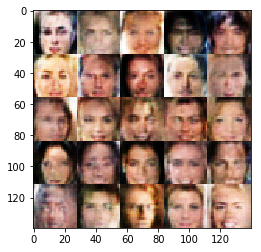

Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 0.7306... Generator Loss: 1.5479
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 1.4201
Epoch 1/1... Discriminator Loss: 0.7826... Generator Loss: 1.6170
Epoch 1/1... Discriminator Loss: 1.6474... Generator Loss: 0.4855
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 0.8103... Generator Loss: 1.4494


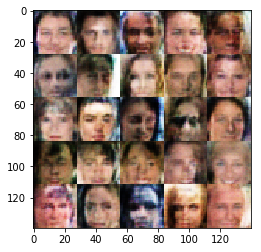

Epoch 1/1... Discriminator Loss: 0.7296... Generator Loss: 1.6012
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 1.0172
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 1.3423
Epoch 1/1... Discriminator Loss: 2.0652... Generator Loss: 0.2668
Epoch 1/1... Discriminator Loss: 0.7574... Generator Loss: 1.4612
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 2.3553
Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 2.2328
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.3334


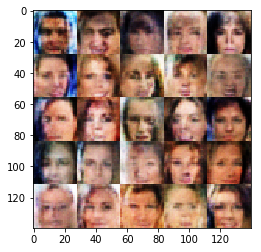

Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 2.5523
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 0.9775
Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 1.1081
Epoch 1/1... Discriminator Loss: 0.7941... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 1.0618
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 3.4496
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.7942


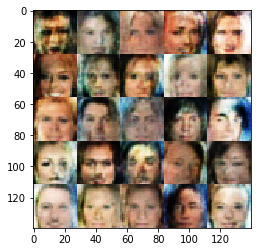

Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 2.3760
Epoch 1/1... Discriminator Loss: 0.8442... Generator Loss: 1.9469
Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 1.3523
Epoch 1/1... Discriminator Loss: 0.7913... Generator Loss: 1.4697
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 2.4656
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.5253
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 0.8222... Generator Loss: 1.5606


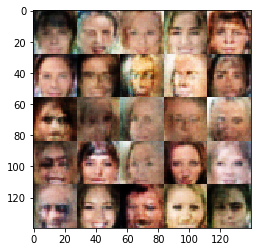

Epoch 1/1... Discriminator Loss: 1.1398... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 3.4520
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 1.2365
Epoch 1/1... Discriminator Loss: 0.9185... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 1.2466
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 1.1876
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 0.7789... Generator Loss: 1.4346


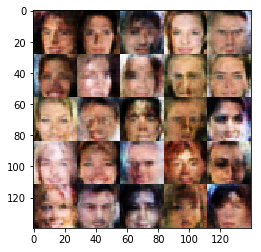

Epoch 1/1... Discriminator Loss: 1.5337... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 1.5735... Generator Loss: 0.4429
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 1.8150
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 0.7968... Generator Loss: 1.4676
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.8456... Generator Loss: 0.3484
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 0.8683


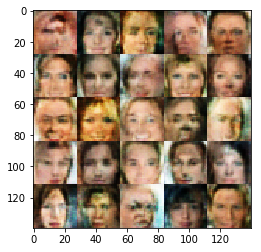

Epoch 1/1... Discriminator Loss: 1.7382... Generator Loss: 0.3962
Epoch 1/1... Discriminator Loss: 1.5472... Generator Loss: 0.4613
Epoch 1/1... Discriminator Loss: 0.7758... Generator Loss: 2.2317
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 2.2971
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.1738
Epoch 1/1... Discriminator Loss: 0.8470... Generator Loss: 1.5683
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 0.6981... Generator Loss: 1.7203
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 2.8245


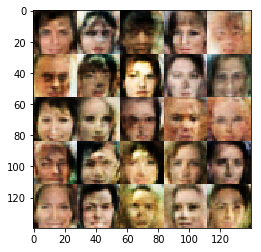

Epoch 1/1... Discriminator Loss: 1.7671... Generator Loss: 0.3455
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.1626
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 2.2728
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 1.2237
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 1.8064
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 1.2842
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.5647


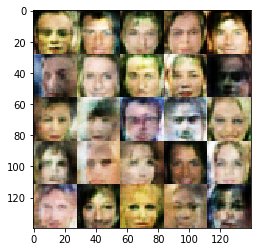

Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.0495
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 1.1405
Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 1.8365
Epoch 1/1... Discriminator Loss: 0.6934... Generator Loss: 2.2930
Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 1.7430
Epoch 1/1... Discriminator Loss: 0.5909... Generator Loss: 2.1958
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 3.1232
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 0.9248... Generator Loss: 1.7806


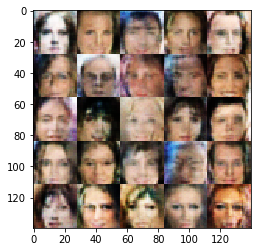

Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.4827
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 1.7113
Epoch 1/1... Discriminator Loss: 0.7038... Generator Loss: 1.6482
Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 1.5393
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 1.0913
Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 1.9620
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 1.0122


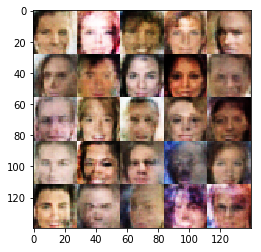

Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 1.2736
Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 1.3756
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 3.0511
Epoch 1/1... Discriminator Loss: 0.8463... Generator Loss: 1.2216
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 0.7658... Generator Loss: 1.6649
Epoch 1/1... Discriminator Loss: 0.8978... Generator Loss: 2.1177


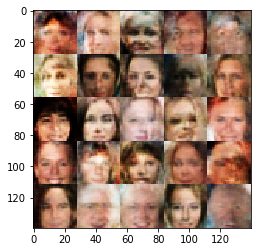

Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 1.3774
Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 1.9526
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 0.8325... Generator Loss: 1.2782
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 2.1946
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.3731
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.6073
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 0.8935


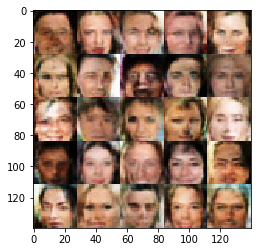

Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 1.4535
Epoch 1/1... Discriminator Loss: 0.7999... Generator Loss: 1.3517
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.2435
Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 2.0416
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 0.9955


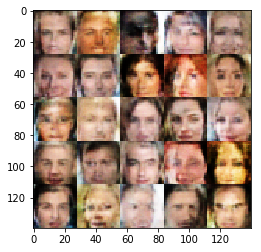

Epoch 1/1... Discriminator Loss: 0.6898... Generator Loss: 2.2258
Epoch 1/1... Discriminator Loss: 0.7396... Generator Loss: 1.5436
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 1.4515
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 1.4588
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 1.3229
Epoch 1/1... Discriminator Loss: 0.9140... Generator Loss: 1.1034
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 1.6886


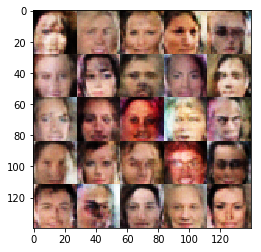

Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 0.6922... Generator Loss: 1.8665
Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 1.1693
Epoch 1/1... Discriminator Loss: 0.7489... Generator Loss: 1.4692
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.6688... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 1.4681
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 1.8702
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 0.9124


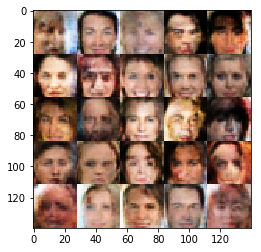

Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.0713
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.8441
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 3.0424
Epoch 1/1... Discriminator Loss: 0.7094... Generator Loss: 1.7500
Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 1.2290
Epoch 1/1... Discriminator Loss: 0.7310... Generator Loss: 1.5845


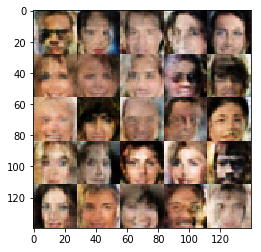

Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.9375
Epoch 1/1... Discriminator Loss: 0.7876... Generator Loss: 1.5128
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.4410
Epoch 1/1... Discriminator Loss: 0.7350... Generator Loss: 1.4667
Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 2.1218
Epoch 1/1... Discriminator Loss: 0.9672... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 1.3619
Epoch 1/1... Discriminator Loss: 2.0001... Generator Loss: 0.3479
Epoch 1/1... Discriminator Loss: 0.7091... Generator Loss: 1.7152


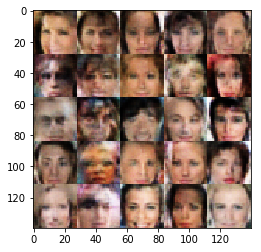

Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 1.4293
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 1.4318
Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 1.2279
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 2.0781
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.1467


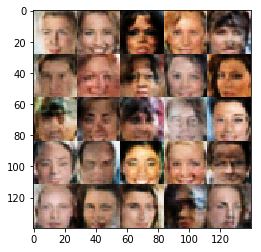

Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 3.6189
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 1.1537
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 3.3802
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.2563
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 0.8513... Generator Loss: 1.1532
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 2.4071


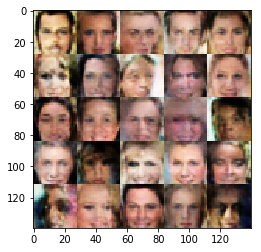

Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 1.7101
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 1.2666
Epoch 1/1... Discriminator Loss: 1.5866... Generator Loss: 0.4633
Epoch 1/1... Discriminator Loss: 1.7097... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.5376
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 1.7533
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 3.8208
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 1.8024
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.5277
Epoch 1/1... Discriminator Loss: 0.7348... Generator Loss: 1.5002


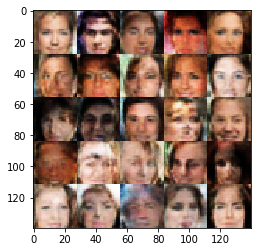

Epoch 1/1... Discriminator Loss: 0.6691... Generator Loss: 1.8693
Epoch 1/1... Discriminator Loss: 0.7876... Generator Loss: 1.4056
Epoch 1/1... Discriminator Loss: 0.7798... Generator Loss: 1.3937
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 1.3657
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 1.3585
Epoch 1/1... Discriminator Loss: 0.6505... Generator Loss: 2.0227
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 0.9412


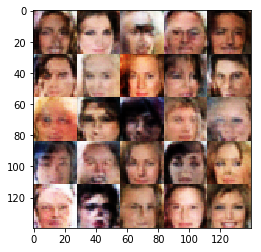

Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 3.6944
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 1.6673
Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 1.4263
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 1.6712
Epoch 1/1... Discriminator Loss: 0.7334... Generator Loss: 1.6208
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 3.1302
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 1.5108
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 1.6904
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 1.1745


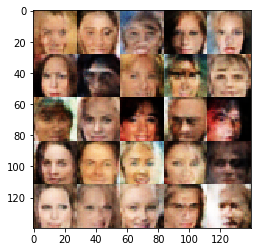

Epoch 1/1... Discriminator Loss: 0.7770... Generator Loss: 1.3453
Epoch 1/1... Discriminator Loss: 0.7388... Generator Loss: 1.5277
Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 1.9372
Epoch 1/1... Discriminator Loss: 1.8678... Generator Loss: 0.3296
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 1.0357
Epoch 1/1... Discriminator Loss: 0.6303... Generator Loss: 2.0130
Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 1.9669
Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 0.9516


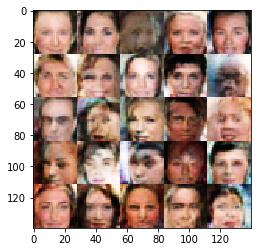

Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 1.4086
Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 1.8219
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 1.3545
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 1.9454
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 1.2894
Epoch 1/1... Discriminator Loss: 1.7431... Generator Loss: 0.4304
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 0.7127... Generator Loss: 1.8612


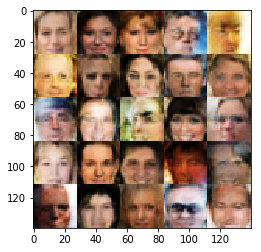

Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.4928
Epoch 1/1... Discriminator Loss: 0.8854... Generator Loss: 2.4165
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.1453
Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 1.3979
Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 1.6135
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 1.3702
Epoch 1/1... Discriminator Loss: 0.6155... Generator Loss: 1.9774
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 0.7129... Generator Loss: 1.6445


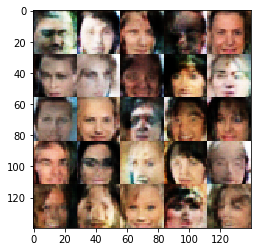

Epoch 1/1... Discriminator Loss: 1.5623... Generator Loss: 0.4204
Epoch 1/1... Discriminator Loss: 0.8297... Generator Loss: 1.6420
Epoch 1/1... Discriminator Loss: 0.7087... Generator Loss: 1.7126
Epoch 1/1... Discriminator Loss: 1.5786... Generator Loss: 0.4754
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 0.9495
Epoch 1/1... Discriminator Loss: 1.7958... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 0.7970... Generator Loss: 1.2756
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 0.8324


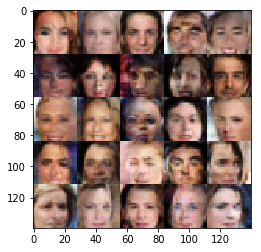

Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 0.9644
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 2.0206
Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 1.9090
Epoch 1/1... Discriminator Loss: 1.7351... Generator Loss: 0.3893
Epoch 1/1... Discriminator Loss: 0.6982... Generator Loss: 1.6774
Epoch 1/1... Discriminator Loss: 0.8048... Generator Loss: 1.3781
Epoch 1/1... Discriminator Loss: 1.7662... Generator Loss: 0.4194
Epoch 1/1... Discriminator Loss: 0.8552... Generator Loss: 1.2320
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 0.7359... Generator Loss: 1.6533


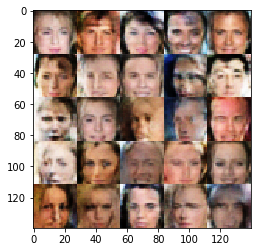

Epoch 1/1... Discriminator Loss: 0.6602... Generator Loss: 2.0038
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 0.8795... Generator Loss: 1.1324
Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 2.1717
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 0.7197... Generator Loss: 1.5376
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 2.0545... Generator Loss: 0.2799
Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 1.2832


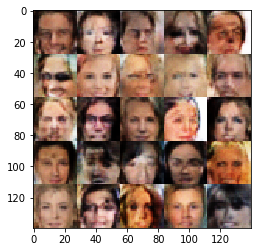

Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.9544
Epoch 1/1... Discriminator Loss: 0.6847... Generator Loss: 1.6650
Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 2.1124
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.7169... Generator Loss: 4.3050
Epoch 1/1... Discriminator Loss: 0.7042... Generator Loss: 1.6091
Epoch 1/1... Discriminator Loss: 1.7566... Generator Loss: 0.3714
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 1.9312


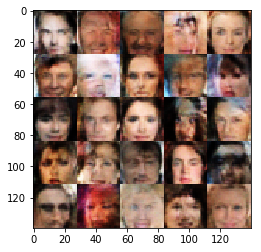

Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 1.1936
Epoch 1/1... Discriminator Loss: 0.7118... Generator Loss: 1.7975
Epoch 1/1... Discriminator Loss: 0.5898... Generator Loss: 2.2372
Epoch 1/1... Discriminator Loss: 0.5981... Generator Loss: 2.4695
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 1.5958
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.2925
Epoch 1/1... Discriminator Loss: 0.6797... Generator Loss: 1.7606
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.2922
Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 1.4000
Epoch 1/1... Discriminator Loss: 0.6652... Generator Loss: 1.8192


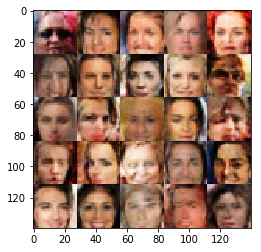

Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.0644
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 0.6923... Generator Loss: 1.7116
Epoch 1/1... Discriminator Loss: 0.7551... Generator Loss: 1.5605
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 1.5620
Epoch 1/1... Discriminator Loss: 0.6470... Generator Loss: 1.9628
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.8191


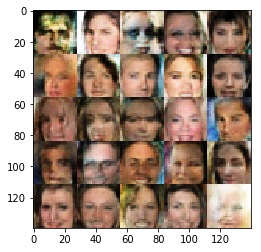

Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 1.9720
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 0.6537... Generator Loss: 2.3773
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 3.2572
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.9316


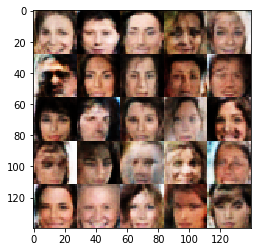

Epoch 1/1... Discriminator Loss: 0.6887... Generator Loss: 1.6470
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 1.3986
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 2.2507
Epoch 1/1... Discriminator Loss: 0.7219... Generator Loss: 1.5678
Epoch 1/1... Discriminator Loss: 2.6397... Generator Loss: 0.2113
Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 0.7139... Generator Loss: 2.1662
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 2.3839... Generator Loss: 0.1977


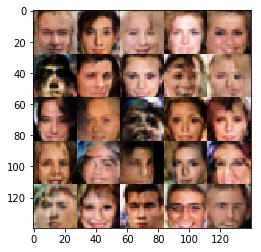

Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.5960
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 1.1516
Epoch 1/1... Discriminator Loss: 0.5518... Generator Loss: 2.4251
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 0.8484... Generator Loss: 1.2216
Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 2.4981
Epoch 1/1... Discriminator Loss: 0.6944... Generator Loss: 1.6343
Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 2.6634
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.7057


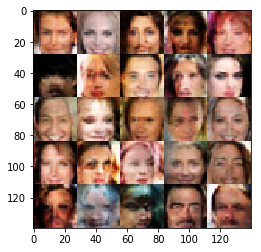

Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.4187
Epoch 1/1... Discriminator Loss: 0.7396... Generator Loss: 1.4471
Epoch 1/1... Discriminator Loss: 2.2639... Generator Loss: 0.2684
Epoch 1/1... Discriminator Loss: 1.6434... Generator Loss: 0.4690
Epoch 1/1... Discriminator Loss: 1.5685... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 2.2470... Generator Loss: 0.2454
Epoch 1/1... Discriminator Loss: 0.6308... Generator Loss: 2.8398
Epoch 1/1... Discriminator Loss: 0.6753... Generator Loss: 1.7376
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 1.0103
Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 1.2267


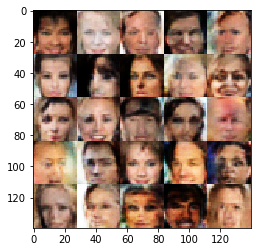

Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 2.5215... Generator Loss: 0.1832
Epoch 1/1... Discriminator Loss: 0.5885... Generator Loss: 2.3051
Epoch 1/1... Discriminator Loss: 0.5332... Generator Loss: 3.0293
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 2.8668
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.1131
Epoch 1/1... Discriminator Loss: 0.7359... Generator Loss: 2.5984


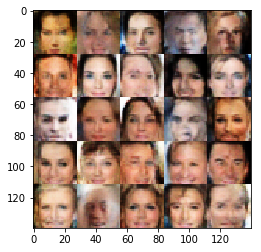

Epoch 1/1... Discriminator Loss: 2.2532... Generator Loss: 0.3245
Epoch 1/1... Discriminator Loss: 0.5634... Generator Loss: 2.6153
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.6900
Epoch 1/1... Discriminator Loss: 0.7215... Generator Loss: 1.5758
Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 2.2497
Epoch 1/1... Discriminator Loss: 0.6062... Generator Loss: 2.0934
Epoch 1/1... Discriminator Loss: 1.7781... Generator Loss: 3.7656
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 0.6336... Generator Loss: 2.8074
Epoch 1/1... Discriminator Loss: 0.6022... Generator Loss: 2.2102


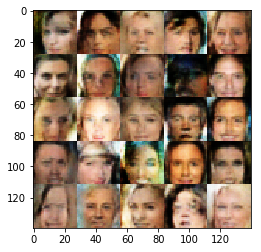

Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 1.6541
Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 2.8140
Epoch 1/1... Discriminator Loss: 0.4960... Generator Loss: 3.1373
Epoch 1/1... Discriminator Loss: 0.6858... Generator Loss: 1.8743
Epoch 1/1... Discriminator Loss: 0.7300... Generator Loss: 1.5405
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 2.0798
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 1.6523
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.5119


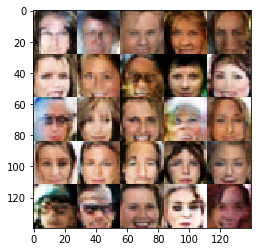

Epoch 1/1... Discriminator Loss: 1.8963... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 0.8051... Generator Loss: 1.2881
Epoch 1/1... Discriminator Loss: 0.6948... Generator Loss: 1.6522
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 0.6581... Generator Loss: 1.9410
Epoch 1/1... Discriminator Loss: 0.6483... Generator Loss: 1.9427
Epoch 1/1... Discriminator Loss: 0.5760... Generator Loss: 2.5558
Epoch 1/1... Discriminator Loss: 0.7596... Generator Loss: 1.4327
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.8694


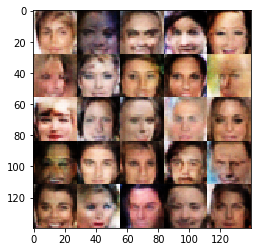

Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 3.7245
Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 2.8354
Epoch 1/1... Discriminator Loss: 0.6750... Generator Loss: 2.2209
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 1.9804
Epoch 1/1... Discriminator Loss: 0.6466... Generator Loss: 1.9092
Epoch 1/1... Discriminator Loss: 0.6212... Generator Loss: 1.9065
Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 1.2075
Epoch 1/1... Discriminator Loss: 0.7279... Generator Loss: 1.5683
Epoch 1/1... Discriminator Loss: 2.2848... Generator Loss: 4.5217
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.5996


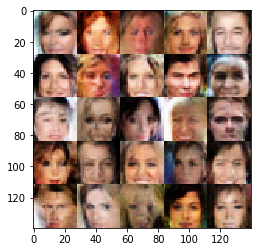

Epoch 1/1... Discriminator Loss: 0.7491... Generator Loss: 2.0545
Epoch 1/1... Discriminator Loss: 0.7411... Generator Loss: 3.1518
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.2080
Epoch 1/1... Discriminator Loss: 0.5390... Generator Loss: 3.3289
Epoch 1/1... Discriminator Loss: 1.6825... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 1.1030
Epoch 1/1... Discriminator Loss: 0.6481... Generator Loss: 1.8439
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 2.4634
Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.6166


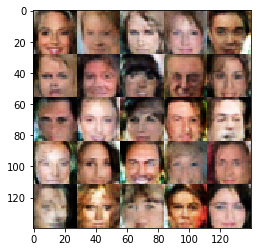

Epoch 1/1... Discriminator Loss: 0.7604... Generator Loss: 1.4216
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 2.2166
Epoch 1/1... Discriminator Loss: 0.7020... Generator Loss: 1.6993
Epoch 1/1... Discriminator Loss: 0.5968... Generator Loss: 3.3588
Epoch 1/1... Discriminator Loss: 1.9443... Generator Loss: 3.9198
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 0.7439... Generator Loss: 1.4634
Epoch 1/1... Discriminator Loss: 0.7020... Generator Loss: 2.1616
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 1.2910
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.5205


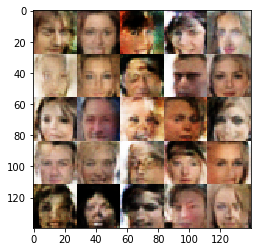

Epoch 1/1... Discriminator Loss: 0.5704... Generator Loss: 2.2217
Epoch 1/1... Discriminator Loss: 0.6632... Generator Loss: 2.0791
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 0.7553... Generator Loss: 2.7427
Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 1.3763
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 1.1533
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.4129
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.3130
Epoch 1/1... Discriminator Loss: 0.7121... Generator Loss: 1.6780
Epoch 1/1... Discriminator Loss: 0.7466... Generator Loss: 3.0489


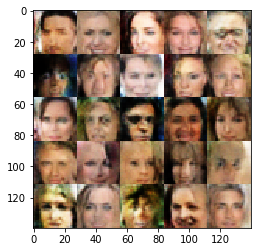

Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 0.6926... Generator Loss: 2.2997
Epoch 1/1... Discriminator Loss: 0.5629... Generator Loss: 2.4443
Epoch 1/1... Discriminator Loss: 0.5599... Generator Loss: 2.4225
Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 2.1443
Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 2.1324
Epoch 1/1... Discriminator Loss: 1.7141... Generator Loss: 0.4624
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 1.1097
Epoch 1/1... Discriminator Loss: 0.6360... Generator Loss: 1.8703
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.6559


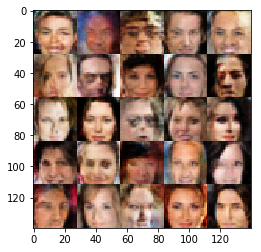

Epoch 1/1... Discriminator Loss: 0.6361... Generator Loss: 1.9735
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 4.5889
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 1.5969
Epoch 1/1... Discriminator Loss: 0.6765... Generator Loss: 1.9474
Epoch 1/1... Discriminator Loss: 1.6923... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 2.0212
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 1.5711
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.7996


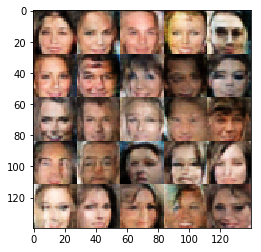

Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 1.8780
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 2.8940
Epoch 1/1... Discriminator Loss: 0.6674... Generator Loss: 1.8923
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 1.5721
Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 2.0075
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 2.8185
Epoch 1/1... Discriminator Loss: 0.7123... Generator Loss: 1.5937
Epoch 1/1... Discriminator Loss: 0.8589... Generator Loss: 1.4415
Epoch 1/1... Discriminator Loss: 0.9250... Generator Loss: 1.1709


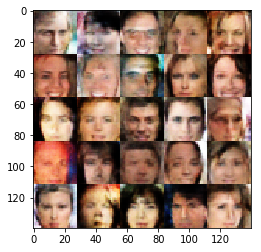

Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.8082
Epoch 1/1... Discriminator Loss: 0.6915... Generator Loss: 2.7960
Epoch 1/1... Discriminator Loss: 0.7471... Generator Loss: 1.4488
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 1.4191
Epoch 1/1... Discriminator Loss: 0.5858... Generator Loss: 2.7378
Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 1.8474
Epoch 1/1... Discriminator Loss: 1.6792... Generator Loss: 0.5442
Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 1.8769
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 0.6645... Generator Loss: 1.7848


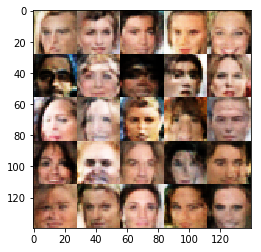

Epoch 1/1... Discriminator Loss: 0.7270... Generator Loss: 2.0918
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 0.5693... Generator Loss: 3.3697


In [32]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.